# PCA Reconstruction (SNWD)

This notebook mirrors the loading paths from `pca_reconstruction_viewer.ipynb`, visualizes the top principal components for `SNWD`, and compares selected original signals with their PCA reconstructions.


In [11]:
from pathlib import Path
from typing import Iterable, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

PCA_RESULTS_DIR = Path("../../weather_info/pca_results")
COEFFICIENTS_PATH = Path("../../../../weather_data/per_row_coefficients.parquet")

MEASUREMENT_TYPES = ["SNWD", "PRCP", "TMIN", "SNOW", "TMAX", "TOBS", "TAVG"]


In [12]:
def load_pca_results(pca_dir: Path, measurement_types: Optional[Iterable[str]] = None) -> dict[str, dict[str, np.ndarray]]:
    measurement_types = measurement_types or MEASUREMENT_TYPES
    results: dict[str, dict[str, np.ndarray]] = {}
    for name in measurement_types:
        path = pca_dir / f"{name.lower()}_pca_results.pkl"
        if not path.exists():
            continue
        with path.open("rb") as fh:
            results[name] = pickle.load(fh)
    if "SNWD" not in results:
        raise FileNotFoundError("SNWD PCA results not found; please confirm inputs")
    return results


def load_coefficients(coefficients_path: Path) -> pd.DataFrame:
    df = pd.read_parquet(coefficients_path)
    if "ELEMENT" not in df.columns:
        raise ValueError("Expected 'ELEMENT' column to filter measurement types")
    return df



In [13]:
import pickle

pca_results = load_pca_results(PCA_RESULTS_DIR)
coefficients_df = load_coefficients(COEFFICIENTS_PATH)
snwd_coeffs = coefficients_df[coefficients_df["ELEMENT"] == "SNWD"].copy()

day_columns = sorted(
    [col for col in snwd_coeffs.columns if col.startswith("day_")],
    key=lambda name: int(name.split("_")[1]),
)

pca_snwd = pca_results["SNWD"]
snwd_mean = pca_snwd["mean"]
snwd_components = pca_snwd["components"]
pc_columns = [f"PC{i + 1}" for i in range(snwd_components.shape[0]) if f"PC{i + 1}" in snwd_coeffs.columns]



In [14]:
print(list(coefficients_df.columns))

['station_id_x', 'latitude', 'longitude', 'elevation', 'state', 'name', 'gsn_flag', 'hcn_crn_flag', 'wmo_id', 'ID', 'year', 'ELEMENT', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'day_7', 'day_8', 'day_9', 'day_10', 'day_11', 'day_12', 'day_13', 'day_14', 'day_15', 'day_16', 'day_17', 'day_18', 'day_19', 'day_20', 'day_21', 'day_22', 'day_23', 'day_24', 'day_25', 'day_26', 'day_27', 'day_28', 'day_29', 'day_30', 'day_31', 'day_32', 'day_33', 'day_34', 'day_35', 'day_36', 'day_37', 'day_38', 'day_39', 'day_40', 'day_41', 'day_42', 'day_43', 'day_44', 'day_45', 'day_46', 'day_47', 'day_48', 'day_49', 'day_50', 'day_51', 'day_52', 'day_53', 'day_54', 'day_55', 'day_56', 'day_57', 'day_58', 'day_59', 'day_60', 'day_61', 'day_62', 'day_63', 'day_64', 'day_65', 'day_66', 'day_67', 'day_68', 'day_69', 'day_70', 'day_71', 'day_72', 'day_73', 'day_74', 'day_75', 'day_76', 'day_77', 'day_78', 'day_79', 'day_80', 'day_81', 'day_82', 'day_83', 'day_84', 'day_85', 'day_86', 'day_87', 'day

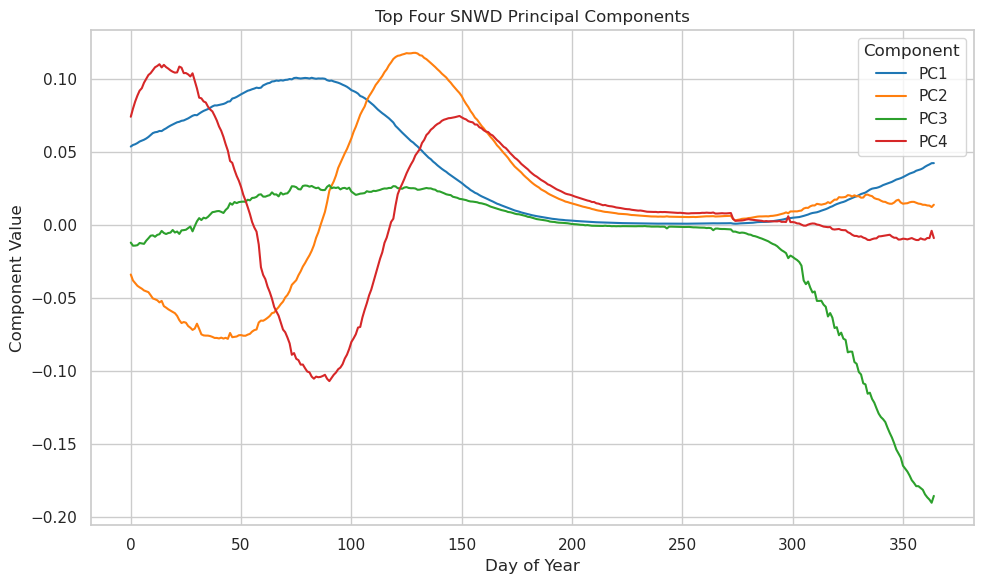

In [15]:
fig, ax = plt.subplots(figsize=(10, 6))
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]
for idx in range(4):
    ax.plot(snwd_components[idx], label=f"PC{idx + 1}", color=colors[idx])
ax.set_xlabel("Day of Year")
ax.set_ylabel("Component Value")
ax.set_title("Top Four SNWD Principal Components")
ax.legend(title="Component")
fig.tight_layout()
fig.show()


In [16]:
def reconstruct_signal(row: pd.Series, max_pc: Optional[int] = None) -> np.ndarray:
    coeffs = np.array([row[col] for col in pc_columns], dtype=float)
    if max_pc is not None:
        coeffs[max_pc:] = 0
    return snwd_mean + coeffs @ snwd_components


def reconstruction_error(original: np.ndarray, reconstructed: np.ndarray) -> dict[str, float]:
    # Compute errors robust to NaNs: ignore positions with NaN in original or reconstructed
    mask = ~np.isnan(original) & ~np.isnan(reconstructed)
    if not np.any(mask):
        # If no valid samples, return nan for both errors
        return {"mse": np.nan, "mae": np.nan}
    residual = original[mask] - reconstructed[mask]
    mse = np.mean(residual ** 2)
    mae = np.mean(np.abs(residual))
    return {"mse": mse, "mae": mae}


def score_candidates(df: pd.DataFrame, sample: int = 5000) -> pd.DataFrame:
    subset = df.sample(n=min(sample, len(df)), random_state=42)
    records = []
    for idx, row in subset.iterrows():
        original = row[day_columns].to_numpy(dtype=float)
        reconstructed = reconstruct_signal(row)
        errors = reconstruction_error(original, reconstructed)
        records.append(
            {
                "index": idx,
                "mse": errors["mse"],
                "mae": errors["mae"],
                "max_abs_pc": np.max(np.abs([row[col] for col in pc_columns])),
            }
        )
    return pd.DataFrame(records).sort_values("mse")



In [17]:
scores = score_candidates(snwd_coeffs, sample=4000)
low_error = scores[scores["mse"] < 50]

def pick_extremes(df: pd.DataFrame, count: int = 3) -> list[int]:
    if df.empty:
        return scores.head(count).index.tolist()
    extremes = df.sort_values("max_abs_pc", ascending=False).head(count).index.tolist()
    return extremes

selected_indices = pick_extremes(low_error, count=4)
selected_rows = snwd_coeffs.loc[selected_indices]
selected_rows


,station_id_x,latitude,longitude,elevation,state,name,gsn_flag,hcn_crn_flag,wmo_id,ID,...,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
2180,HUM00012982,46.2500,20.1000,83.0,None,SZEGED (AUT),None,None,12982.0,HUM00012982,...,-2604.639726,785.164239,399.091266,-271.917347,40.160557,-8.648430,-19.400228,14.225949,-10.413981,2.267279
2406,NOE00109561,59.6244,9.6378,170.0,None,KONGSBERG BRANNSTASJON,None,None,NaN,NOE00109561,...,3160.043477,-1781.385189,1342.851226,-899.098738,-638.250477,-589.684420,-159.633813,211.108484,-142.507484,-180.671518
3999,US10garf004,42.0580,-98.9925,691.0,NE,BURWELL 20.4 NNE,None,None,NaN,US10garf004,...,-2593.752888,778.785736,395.527812,-253.196733,65.275422,-34.525796,-16.733046,-1.574782,16.388074,-23.282599
225,CA001123280,49.4667,-120.7333,1037.0,BC,GRANITE CREEK,None,None,NaN,CA001123280,...,3897.796400,-2349.555978,1165.274819,1376.235233,1373.531092,-341.754452,-327.504364,566.311535,802.371273,-585.877156


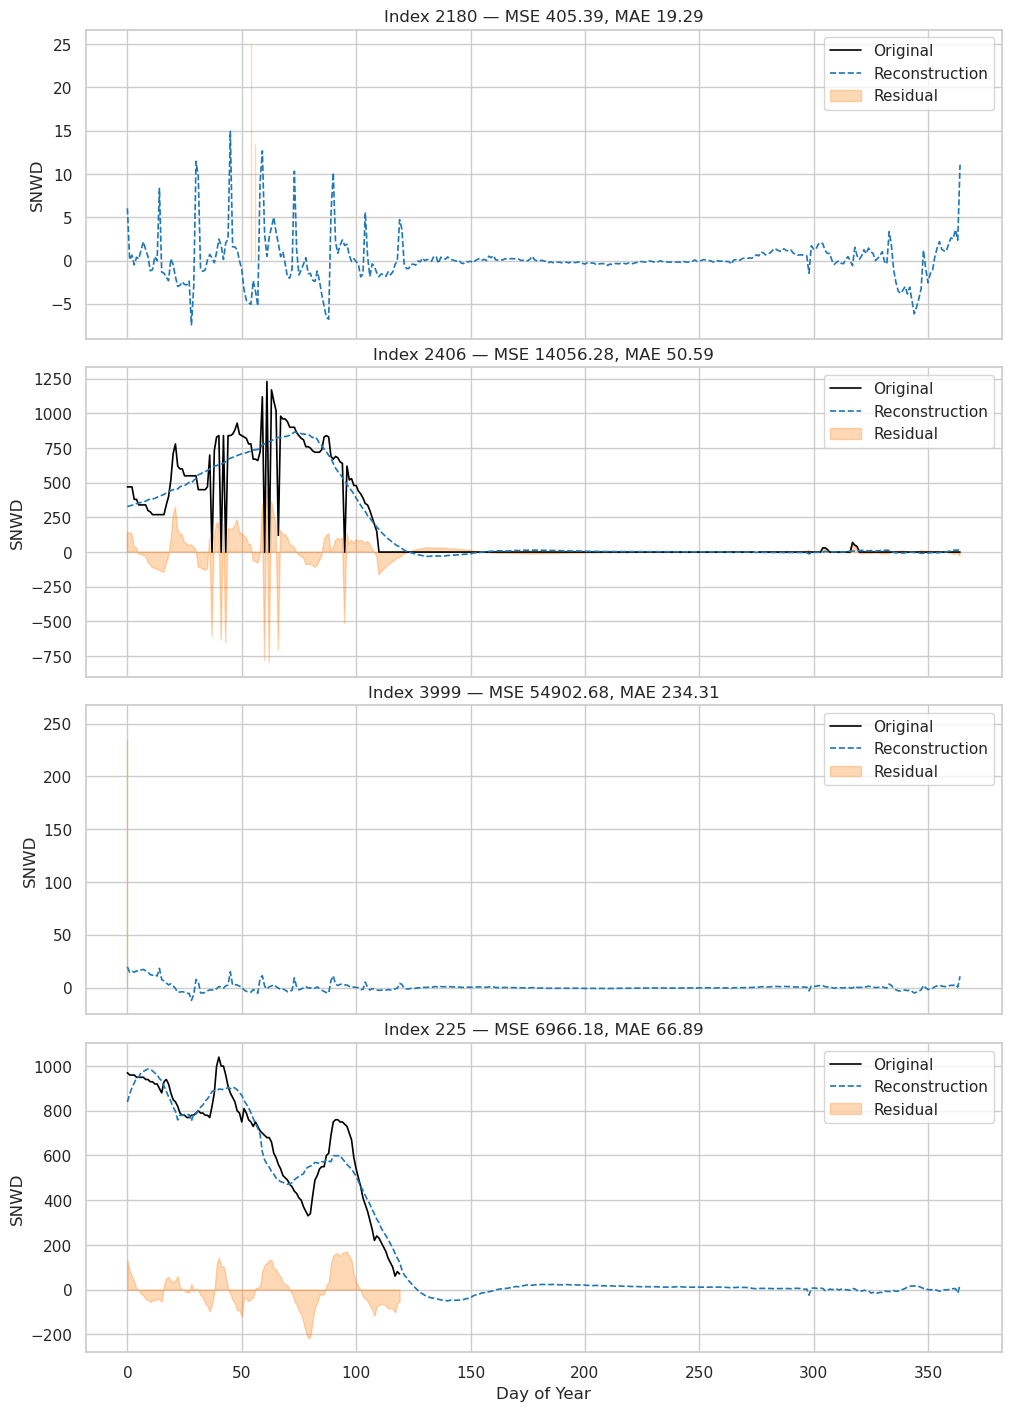

In [18]:
fig, axes = plt.subplots(len(selected_rows), 1, figsize=(10, 3.5 * len(selected_rows)), sharex=True, constrained_layout=True)
if len(selected_rows) == 1:
    axes = [axes]

for ax, (idx, row) in zip(axes, selected_rows.iterrows()):
    original = row[day_columns].to_numpy(dtype=float)
    reconstructed = reconstruct_signal(row)
    residual = original - reconstructed
    metrics = reconstruction_error(original, reconstructed)

    ax.plot(original, color="black", linewidth=1.2, label="Original")
    ax.plot(reconstructed, color="tab:blue", linestyle="--", linewidth=1.2, label="Reconstruction")
    ax.fill_between(range(len(residual)), 0, residual, color="tab:orange", alpha=0.3, label="Residual")
    ax.set_ylabel("SNWD")
    ax.set_title(
        f"Index {idx} — MSE {metrics['mse']:.2f}, MAE {metrics['mae']:.2f}"
    )
    ax.legend(loc="upper right")

axes[-1].set_xlabel("Day of Year")
plt.show()


In [19]:
def summarize_selection(rows: pd.DataFrame) -> pd.DataFrame:
    records = []
    for idx, row in rows.iterrows():
        original = row[day_columns].to_numpy(dtype=float)
        reconstructed = reconstruct_signal(row)
        metrics = reconstruction_error(original, reconstructed)
        coeffs = row[pc_columns].astype(float)
        top_coeffs = coeffs.abs().sort_values(ascending=False).head(4).index.tolist()

        record = {
            "index": idx,
            "mse": metrics["mse"],
            "mae": metrics["mae"],
            "max_abs_pc": coeffs.abs().max(),
        }
        for rank, name in enumerate(top_coeffs, start=1):
            record[f"top{rank}_pc"] = name
            record[f"top{rank}_coeff"] = coeffs[name]
        records.append(record)

    return pd.DataFrame(records).set_index("index")

summary = summarize_selection(selected_rows)
summary

,mse,mae,max_abs_pc,top1_pc,top1_coeff,top2_pc,top2_coeff,top3_pc,top3_coeff,top4_pc,top4_coeff
index,,,,,,,,,,,
2180,405.385642,19.290406,2604.639726,PC1,-2604.639726,PC2,785.164239,PC3,399.091266,PC4,-271.917347
2406,14056.281836,50.592136,3160.043477,PC1,3160.043477,PC2,-1781.385189,PC3,1342.851226,PC4,-899.098738
3999,54902.678474,234.313206,2593.752888,PC1,-2593.752888,PC2,778.785736,PC3,395.527812,PC4,-253.196733
225,6966.180361,66.894710,3897.796400,PC1,3897.796400,PC2,-2349.555978,PC4,1376.235233,PC5,1373.531092


In [ ]:
# The columns 'mse' (mean squared error) and 'mae' (mean absolute error) quantify the reconstruction error
# between the original and PCA-reconstructed SNWD signals:
#   - 'mse' measures the average squared difference,
#   - 'mae' measures the average absolute difference.
# The 'max_abs_pc' column gives the maximum absolute value among the PCA coefficients for each selected signal,
# intended as a summary of coefficient extremeness.

: 